In [1]:
import sys
sys.path.extend(['..'])

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stan
import json
from pathlib import Path
from tqdm.auto import trange
import stan

import nest_asyncio
nest_asyncio.apply()

%matplotlib inline

__Create mixture of sinusoids__

In [3]:
class RandomMixtureOfSinusoids(object):
    def __init__(self, dim, freqs, alpha):
        self._dim = dim
        self._omega = np.array(freqs)
        self._alpha = alpha
        self._weights = (self._omega ** alpha) / np.sum(self._omega ** alpha)
        self.randomize()
    
    def set_alpha(self, a):
        self._alpha = a
        self._weights = (self._omega ** a) / np.sum(self._omega ** a)
    
    def randomize(self):
        self._phases = np.random.rand(len(self._omega)) * 2 * np.pi
        self._t = np.random.randn(len(self._omega), self._dim)
        self._t = self._t / np.linalg.norm(self._t, axis=1, keepdims=True)
    
    def __call__(self, x, total=True):
        dot_tx = self._t @ x
        if total:
            return np.sum(self._weights[:,None] * np.sin(dot_tx*self._omega[:,None] + self._phases[:,None]), axis=0)
        else:
            return self._weights[:,None], np.sin(dot_tx*self._omega[:,None] + self._phases[:,None])

    def gauss_expectation(self, mean, cov, total=True):
        dot_tmu = self._t @ mean
        tCt = np.sum(self._t * (self._t @ cov), axis=1)
        if np.min(tCt) < 0.:
            print("WTF1")
        sin_part = np.sin(dot_tmu*self._omega + self._phases)
        exp_part = np.exp(-0.5 * tCt * self._omega**2)
        if total:
            return np.sum(self._weights * sin_part * exp_part)
        else:
            return self._weights, sin_part * exp_part


class LazyMixtureOfSinusoids(object):
    def __init__(self, dim, freqs, x=None, mus=None, covs=None, t=None):
        if not ((x is None) ^ (mus is None)):
            raise ValueError("Must set exactly one of x values or (mus, covs) to evaluate")

        self._dim = dim
        self._omega = np.array(freqs)
    
        if t is not None:
            self._t = np.copy(t)
        else:
            # Choose random unit directions
            self._t = np.random.randn(len(self._omega), self._dim)
            self._t = self._t / np.linalg.norm(self._t, axis=1, keepdims=True)
        
        # Precompute table of values of size (len(freqs), len(x))
        if x is not None:
            dot_tx = self._t @ x
            self._sin_table = np.sin(dot_tx*self._omega[:,None])
            self._cos_table = np.cos(dot_tx*self._omega[:,None])
        elif mus is not None:
            tmu = np.einsum('fa,ax->fx', self._t, mus)
            tCt = np.einsum('fa,fb,abx->fx', self._t, self._t, covs)
            if np.min(tCt) < 0.:
                print("WTF2")
            # print("mus", mus.shape, "covs", covs.shape, "tmu", tmu.shape, "tCt", tCt.shape)
            self._sin_table = np.sin(tmu*self._omega[:,None]) * np.exp(-0.5 * tCt * self._omega[:,None]**2)
            self._cos_table = np.cos(tmu*self._omega[:,None]) * np.exp(-0.5 * tCt * self._omega[:,None]**2)
    
    def apply(self, weights, phases):
        """Use precomputed sin and cos tables to get sum of sin(omega*x+phase) using the identity
        sin(ax+b) = cos(ax)sin(b) + sin(ax)cos(b)
        """
        return weights @ (self._cos_table * np.sin(phases[:, None]) + self._sin_table * np.cos(phases[:, None]))


Text(0, 0.5, 'analytic E[f]')

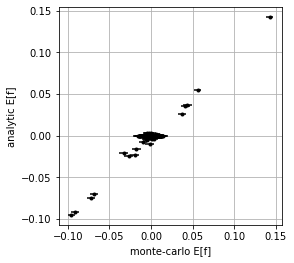

In [4]:
dim = 2
freqs = np.arange(1, 301, dtype='float32')*2*np.pi

plt.figure(figsize=(4,4))
f = RandomMixtureOfSinusoids(dim, freqs, -1.1)
for i in range(300):
    mu = np.random.randn(dim)
    cov = np.random.randn(dim,dim)
    cov = cov.T@cov + np.eye(dim)*.01
    x_samples = np.random.multivariate_normal(mu, cov, (1000,))
    f_samples = f(x_samples.T)
    mc_val, mcse = np.mean(f_samples), np.std(f_samples) / np.sqrt(1000)
    ana_val = f.gauss_expectation(mu, cov)
    plt.errorbar(mc_val, ana_val, yerr=0, xerr=mcse, marker='.', color='k')
plt.axis('equal')
plt.grid('on')
plt.xlabel('monte-carlo E[f]')
plt.ylabel('analytic E[f]')

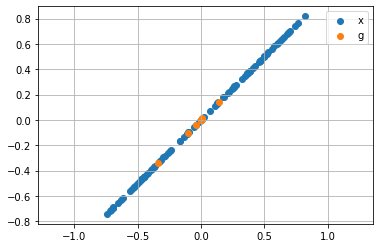

In [5]:
x = np.random.randn(dim, 100)*2
mus = np.random.randn(dim, 100)*2
covs = np.random.randn(dim, dim, 100)
covs = np.moveaxis(np.matmul(np.transpose(covs, (2, 0, 1)), np.transpose(covs, (2, 1, 0))), 0, -1)

mix1 = RandomMixtureOfSinusoids(dim, freqs, -2)
vals1_x = mix1(x)
vals1_g = [mix1.gauss_expectation(m, c) for m, c in zip(np.moveaxis(mus, -1, 0), np.moveaxis(covs, -1, 0))]

mix2_x = LazyMixtureOfSinusoids(dim, freqs, x, t=mix1._t)
mix2_g = LazyMixtureOfSinusoids(dim, freqs, None, mus, covs, t=mix1._t)
vals2_x = mix2_x.apply(mix1._weights, mix1._phases)
vals2_g = mix2_g.apply(mix1._weights, mix1._phases)

plt.scatter(vals1_x, vals2_x, label='x')
plt.scatter(vals1_g, vals2_g, label='g')
plt.axis('equal')
plt.grid('on')
plt.legend()

## Animate wiggliness

In [6]:
from matplotlib import animation

x = np.linspace(-1, 1, 500)
xx, yy = np.meshgrid(x, x)
xy = np.stack([xx.flatten(), yy.flatten()], axis=0)

alphas = np.linspace(-3, -1)
alphas = np.concatenate([np.flip(alphas), alphas])

f1 = LazyMixtureOfSinusoids(dim=1, freqs=freqs, x=x[None, :])
f2 = LazyMixtureOfSinusoids(dim=2, freqs=freqs, x=xy)

phases = np.random.rand(freqs.size)*2*np.pi

def weights(a):
    return (freqs ** a) / (freqs[0] ** a)


fig, axs = plt.subplots(1, 3, figsize=(9, 3))

handles = [None]*3
def init():
    handles[0], = axs[0].loglog(freqs, weights(alphas[0]), '-k', linewidth=2)
    axs[0].set_xlabel('frequency')
    axs[0].set_ylabel('amplitude')
    axs[0].set_title(r'$\alpha$='+f'{alphas[0]:.1f}')
    axs[0].grid('on')

    handles[1], = axs[1].plot(x, f1.apply(weights(alphas[0]), phases), '-k', linewidth=2)
    axs[1].set_xlabel('x')
    axs[1].set_title('example f(x) in 1D')

    handles[2] = axs[2].imshow(np.reshape(f2.apply(weights(alphas[0]), phases), xx.shape), cmap='Greys')
    axs[2].set_xlabel('$x_1$')
    axs[2].set_ylabel('$x_2$')
    axs[2].set_title('example f(x) in 2D')
    
    fig.tight_layout()
    
    return fig,

progbar = trange(len(alphas), desc='frames')
def update(i):
    progbar.update(1)

    axs[0].set_title(r'$\alpha$='+f'{alphas[i]:.1f}')
    handles[0].set_data(freqs, weights(alphas[i]))
    handles[1].set_data(x, f1.apply(weights(alphas[i]), phases))
    handles[2].set_data(np.reshape(f2.apply(weights(alphas[i]), phases), xx.shape))
    
    return fig,

anim = animation.FuncAnimation(fig, update, init_func=init, frames=len(alphas))
anim.save("alpha_wiggliness.gif", writer=animation.PillowWriter(fps=30), dpi=300)
plt.close(fig)

frames:   0%|          | 0/100 [00:00<?, ?it/s]